In [1]:
%load_ext autoreload
%autoreload 2

from trainer import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

configfile = 'base_SNL_MSU_DOE_avg'

trainer = Trainer(device=device)
trainer.load_config(default_configfile=configfile)
trainer.load_data()

Using cpu device
{'project': 'SNL_MSU_DOE_avg', 'model': 'MLP', 'loss': 'mse', 'split_by': 'random', 'bayes_opt': False, 'bayes_epoch': 10, 'patience': 50, 'epoch': 200, 'lr': 0.003, 'weight_decay': 0.002, 'batch_size': 1024, 'static_params': {'patience': 50, 'epoch': 200}, 'chosen_params': {'lr': 0.003, 'weight_decay': 0.002, 'batch_size': 1024}, 'layers': [16, 64, 128, 128, 64, 16], 'n_calls': 100, 'sequence': True, 'SPACEs': {'lr': {'low': 0.001, 'high': 0.05, 'prior': 'log-uniform'}, 'weight_decay': {'low': 1e-05, 'high': 0.05, 'prior': 'log-uniform'}, 'batch_size': {'categories': [32, 64, 128, 256, 512, 1024, 2048, 4096]}}, 'feature_names_type': {'Percentage of Fibre in 0-deg Direction': 1, 'Percentage of Fibre in 45-deg Direction': 1, 'Percentage of Fibre in 90-deg Direction': 1, 'Percentage of Fibre in Other Direction': 1, 'Absolute Maximum Stress': 0, 'Absolute Peak-to-peak Stress': 0, 'Frequency': 0, 'Fibre Volumn Fraction': 1, 'Relative Maximum Stress': 0, 'Relative Peak-to-p

Epoch: 1/200, Train loss: 29.1711, Val loss: 3.7390, Min val loss: 3.7390
Epoch: 100/200, Train loss: 0.2935, Val loss: 0.4982, Min val loss: 0.4723
Epoch: 200/200, Train loss: 0.1907, Val loss: 0.4392, Min val loss: 0.4251
Minimum loss: 0.42513
Test MSE loss: 0.45819, RMSE loss: 0.67690


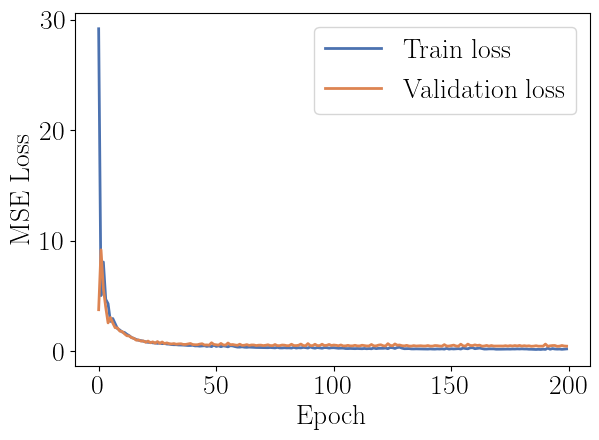

In [2]:
trainer.train()
trainer.plot_loss()

Train Loss: 0.1763, R2: 0.8947
Validation Loss: 0.4251, R2: 0.7213
Test Loss: 0.4582, R2: 0.7203


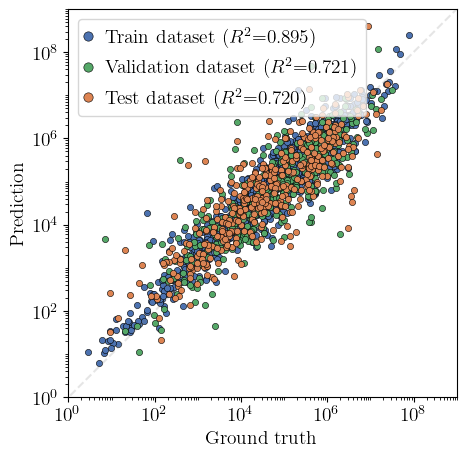

In [3]:
trainer.plot_truth_pred()